# The Variational Quantum Linear Solver

In [1]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, transpile, assemble
import math
import random
import numpy as np
from scipy.optimize import minimize

## 1. Einleitung

Der Variational Quantum Linear Solver oder VQLS ist ein Variationsquantenalgorithmus, der VQE verwendet, um lineare Gleichungssysteme effizienter als klassische Rechenalgorithmen zu lösen. Genauer gesagt, wenn uns eine Matrix $\textbf{A}$ gegeben wird, so dass $\textbf{A} |\textbf{x}\rangle \ = \ |\textbf{b}\rangle$, wobei $|\textbf {b}\rangle$ ein bekannter Vektor ist, ist der VQLS-Algorithmus theoretisch in der Lage, ein normalisiertes $|x\rangle$ zu finden, das proportional zu $|\textbf{x}\rangle$ ist, wodurch die obige Beziehung wahr wird.

Die Ausgabe dieses Algorithmus ist identisch mit der des HHL Quantum Linear-Solving Algorithm, mit der Ausnahme, dass HHL zwar eine viel günstigere Rechengeschwindigkeit gegenüber VQLS bietet, die Variationsnatur unseres Algorithmus es jedoch ermöglicht, dass er auf NISQ-Quantencomputern ausgeführt wird HHL würde viel robustere Quantenhardware und viel mehr Qubits erfordern.


## 2. Der Algorithmus

Die Eingaben in diesen Algorithmus sind zunächst offensichtlich die Matrix $\textbf{A}$, die wir in eine Linearkombination von Unitären mit komplexen Koeffizienten zerlegen müssen:

$$A \ = \ \displaystyle\sum_{n} c_n \ A_n$$

Wobei jedes $A_n$ etwas unitäres ist, und einiges unitäres $U$, das den Zustand $|\textbf{b}\rangle$ aus $|0\rangle$ vorbereitet. Erinnern Sie sich nun an die allgemeine Struktur eines Variationsquantenalgorithmus. Wir müssen eine Quantenkostenfunktion konstruieren, die mit einer parametrisierten Quantenschaltung geringer Tiefe ausgewertet und dann an den klassischen Optimierer ausgegeben werden kann. Dies erlaubt uns, einen Parameterraum nach einem Satz von Parametern $\alpha$ zu durchsuchen, so dass $|\psi(\alpha)\rangle \ = \ \frac{|\textbf{x}\rangle}{|| \textbf{x} ||}$, wobei $|\psi(k)\rangle$ die Ausgabe unserer Quantenschaltung ist, die einem Parametersatz $k$ entspricht.

Bevor wir mit der eigentlichen Konstruktion der Kostenfunktion beginnen, werfen wir einen Blick auf einen "hohen" Überblick über die Unterroutinen innerhalb dieses Algorithmus, wie in diesem Bild aus dem Originalpapier dargestellt:

![Alt-Text](images/bro.png)

Im Wesentlichen beginnen wir also mit einem Qubit-Register, wobei jedes Qubit auf $|0\rangle$ initialisiert wird. Unser Algorithmus nimmt seine Eingaben, bereitet dann die Kostenfunktion vor und wertet sie aus, beginnend mit der Erstellung eines Ansatzes $V(\alpha)$. Wenn die berechneten Kosten größer als ein Parameter $\gamma$ sind, wird der Algorithmus erneut mit aktualisierten Parametern ausgeführt, und wenn nicht, wird der Algorithmus beendet und der Ansatz wird mit den optimalen Parametern (bei Beendigung bestimmt) berechnet. Damit erhalten wir den Zustandsvektor, der unsere Kostenfunktion minimiert, und damit die normalisierte Form von $|\textbf{x}\rangle$.

## 3. Qiskit-Implementierung

### Fester Hardware-Ansatz

Beginnen wir mit der Betrachtung des Ansatzes $V(\alpha)$, der nur eine Schaltung ist, die einen beliebigen Zustand $|\psi(k)\rangle$ vorbereitet. Dies erlaubt uns, den Zustandsraum zu "durchsuchen", indem wir einen Satz von Parametern $k$ variieren. Wie auch immer, der Ansatz, den wir für diese Implementierung verwenden werden, ist wie folgt:

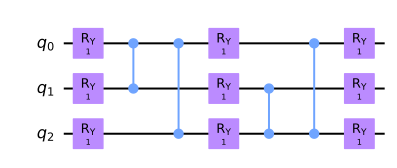

In [2]:
def apply_fixed_ansatz(qubits, parameters):

    for iz in range (0, len(qubits)):
        circ.ry(parameters[0][iz], qubits[iz])

    circ.cz(qubits[0], qubits[1])
    circ.cz(qubits[2], qubits[0])

    for iz in range (0, len(qubits)):
        circ.ry(parameters[1][iz], qubits[iz])

    circ.cz(qubits[1], qubits[2])
    circ.cz(qubits[2], qubits[0])

    for iz in range (0, len(qubits)):
        circ.ry(parameters[2][iz], qubits[iz])

circ = QuantumCircuit(3)
apply_fixed_ansatz([0, 1, 2], [[1, 1, 1], [1, 1, 1], [1, 1, 1]])
circ.draw()

Dies wird als **fester Hardwareansatz bezeichnet** : Die Konfiguration von Quantengattern bleibt für jeden Durchlauf der Schaltung gleich, es ändern sich nur die Parameter. Anders als der QAOA-Ansatz besteht er nicht ausschließlich aus Trotterisierten Hamiltonianern. Die Anwendungen von $Ry$-Gattern ermöglichen es uns, den Zustandsraum zu durchsuchen, während die $CZ$-Gatter eine "Interferenz" zwischen den verschiedenen Qubit-Zuständen erzeugen.

Nun ist es für uns sinnvoll, die tatsächliche **Kostenfunktion** zu betrachten. Das Ziel unseres Algorithmus wird es sein, die Kosten zu minimieren, wenn also $|\Phi\rangle \ = \ \textbf{A} |\psi(k)\rangle$ sehr nahe an $|\textbf{b}\rangle$ liegt , möchten wir, dass die Ausgabe unserer Kostenfunktion sehr klein ist, und wenn die Vektoren nahezu orthogonal sind, möchten wir, dass die Kostenfunktion sehr groß ist. Daher führen wir den „Projektions“-Hamiltonoperator ein:

$$H_P \ = \ \mathbb{I} \ - \ |b\rangle \langle b|$$

Wo haben wir:

$$C_P \ = \ \langle \Phi | H_P | \Phi \rangle \ = \ \langle \Phi | (\mathbb{I}\-\|b\rangle\langle b|) |\Phi\rangle\=\\langle\Phi| \Phi \rangle \ - \ \langle \Phi |b\rangle \langle b | \Phi\rangle$$

Beachten Sie, wie der zweite Term uns sagt, „wie viel“ von $|\Phi\rangle$ entlang $|b\rangle$ liegt. Wir subtrahieren dies dann von einer anderen Zahl, um die gewünschte niedrige Zahl zu erhalten, wenn das innere Produkt von $|\Phi\rangle$ und $|b\rangle$ größer ist (sie stimmen mehr überein), und das Gegenteil, wenn sie nahe daran sind senkrecht. Das sieht bisher gut aus! Es gibt jedoch noch eine weitere Sache, die wir tun können, um die Genauigkeit des Algorithmus zu erhöhen: die Normalisierung der Kostenfunktion. Denn wenn $|\Phi\rangle$ eine kleine Norm hat, dann ist die Kostenfunktion immer noch klein, auch wenn sie nicht mit $|\textbf{b}\rangle$ übereinstimmt. Daher ersetzen wir $|\Phi\rangle$ durch $\frac{|\Phi\rangle}{\sqrt{\langle \Phi | \Phi\rangle}}$:

$$\hat{C}_P \ = \ \frac{\langle \Phi | \Phi \rangle}{\langle \Phi | \Phi \rangle} \ - \ \frac{\langle \Phi |b\rangle \langle b | \Phi \rangle}{\langle \Phi | \Phi\rangle} \ = \ 1 \ - \ \frac{\langle \Phi |b\rangle \langle b | \Phi \rangle}{\langle \Phi | \Phi\rangle}\=\1\-\\frac{|\langle b| \Phi \rangle|^2}{\langle \Phi | \Phi\rangle}$$

Ok, wir haben also unseren Zustand $|\psi(k)\rangle$ mit dem Ansatz vorbereitet. Jetzt müssen wir zwei Werte berechnen, um die Kostenfunktion auszuwerten, nämlich $|\langle b | \Phi \rangle|^2$ und $\langle \Phi | \Phi\rangle$. Glücklicherweise ermöglicht uns eine raffinierte kleine Quanten-Unterroutine namens **Hadamard-Test** , dies zu tun! Im Wesentlichen, wenn wir einen einheitlichen $U$ und einen Zustand $|\phi\rangle$ haben und wir den Erwartungswert von $U$ in Bezug auf den Zustand finden wollen, $\langle \phi | U | \phi \rangle$, dann können wir folgende Schaltung auswerten:

<br><br>

![Bild1](images/h.png)

<br><br>

Dann ist die Wahrscheinlichkeit, das erste Qubit als $0$ zu messen, gleich $\frac{1}{2} (1 \ + \ \text{Re}\langle U \rangle)$ und die Wahrscheinlichkeit, $1$ zu messen, ist gleich $\frac{1}{2} (1 \ - \ \text{Re}\langle U \rangle)$, also ergibt die Subtraktion der beiden Wahrscheinlichkeiten $\text{Re} \langle U \rangle$. Glücklicherweise sind die Matrizen, mit denen wir es zu tun haben, wenn wir diesen Algorithmus testen, völlig real, also $\text{Re} \langle U \rangle \ = \ \langle U \rangle$ für diese spezifische Implementierung. So funktioniert der Hadamard-Test. Nach dem Schaltplan haben wir als unseren allgemeinen Zustandsvektor:

<br>

$$\frac{|0\rangle \ + \ |1\rangle}{\sqrt{2}} \ \otimes \ |\psi\rangle \ = \ \frac{|0\rangle \ \otimes \ |\psi \rangle \ + \ |1\rangle \ \otimes \ |\psi\rangle}{\sqrt{2}}$$

<br>

Anwendung unserer kontrollierten Einheit:

<br>

$$\frac{|0\rangle \ \otimes \ |\psi\rangle \ + \ |1\rangle \ \otimes \ |\psi\rangle}{\sqrt{2}} \ \rightarrow \ \frac{| 0\rangle \ \otimes \ |\psi\rangle \ + \ |1\rangle \ \otimes \ U|\psi\rangle}{\sqrt{2}}$$

<br>

Wenden Sie dann das Hadamard-Gatter auf das erste Qubit an:

<br>

$$\frac{|0\rangle \ \otimes \ |\psi\rangle \ + \ |1\rangle \ \otimes \ U|\psi\rangle}{\sqrt{2}} \ \rightarrow \ \frac{ 1}{2} \ \big[ |0\rangle \ \otimes \ |\psi\rangle \ + \ |1\rangle \ \otimes \ |\psi\rangle \ + \ |0\rangle \ \otimes \ U |\psi\rangle \ - \ |1\rangle \ \otimes \ U|\psi\rangle \big]$$

<br>

$$\Rightarrow \ |0\rangle \ \otimes \ (\mathbb{I} \ + \ U)|\psi\rangle \ + \ |1\rangle \ \otimes \ (\mathbb{I} \ - \ U )|\psi\rangle$$

<br>

Wenn wir eine Messung des ersten Qubits vornehmen, denken Sie daran, dass wir, um die Wahrscheinlichkeit für die Messung von $0$ zu finden, das innere Produkt des Zustandsvektors mit $|0\rangle$ nehmen und dann mit seiner komplexen Konjugierten multiplizieren müssen (siehe die Abschnitt Quantenmechanik, wenn Sie damit nicht vertraut sind). Dasselbe gilt für die Wahrscheinlichkeit, $1$ zu messen. Somit haben wir:

<br>

$$P(0) \ = \ \frac{1}{4} \ \langle \psi | (\mathbb{I} \ + \ U) (\mathbb{I} \ + \ U^{\dagger}) |\psi\rangle \ = \ \frac{1}{4} \ \langle \psi | (\mathbb{I}^2 \ + U \ + \ U^{\dagger} \ + \ U^{\dagger} U) |\psi\rangle \ = \ \frac{1}{4} \ \langle \psi | (2\mathbb{I}\+U\+\U^{\dagger}) |\psi\rangle$$

<br>

$$\Rightarrow \ \frac{1}{4} \Big[ 2 \ + \ \langle \psi | U^{\dolch} | \psi \rangle \ + \ \langle \psi | U | \psi \rangle \Big] \ = \ \frac{1}{4} \Big[ 2 \ + \ (\langle \psi | U | \psi \rangle)^{*} \ + \ \langle \psi | U | \psi \rangle \Big] \ = \ \frac{1}{2} (1 \ + \ \text{Re} \ \langle \psi | U | \psi \rangle)$$

<br>

Durch ein ähnliches Verfahren erhalten wir:

<br>

$$P(1) \ = \ \frac{1}{2} \ (1 \ - \ \text{Re} \ \langle \psi | U | \psi \rangle)$$

<br>

Und so, indem man die Differenz nimmt:

<br>

$$P(0) \ - \ P(1) \ = \ \text{Re} \ \langle \psi | U | \psi\rangle$$

<br>

Cool! Jetzt können wir dies tatsächlich für die beiden Werte implementieren, die wir berechnen müssen. Beginnend mit $\langle \Phi | \Phi \rangle$, wir haben:

<br>

$$\langle \Phi | \Phi\rangle\=\\langle\psi(k)| A^{\dagger} A |\psi(k)\rangle\=\\langle 0 | V(k)^{\dagger} A^{\dagger} AV(k) |0\rangle \ = \ \langle 0 | V(k)^{\dagger} \Big( \displaystyle\sum_{n} c_n \ A_n \Big)^{\dagger} \Big( \displaystyle\sum_{n} c_n \ A_n \Big) V(k) |0\rangle$$

<br>

$$\Rightarrow \ \langle \Phi | \Phi \rangle \ = \ \displaystyle\sum_{m} \displaystyle\sum_{n} c_m^{*} c_n \langle 0 | V(k)^{\dagger} A_m^{\dagger} A_n V(k) |0\rangle$$

<br>

und so wird unsere Aufgabe zur Berechnung aller möglichen Terme $\langle 0 | V(k)^{\dagger} A_m^{\dagger} A_n V(k) |0\rangle$ unter Verwendung des Hadamard-Tests. Dazu müssen wir den Zustand $V(k) |0\rangle$ vorbereiten und dann kontrollierte Operationen mit einigen Kontroll-Hilfs-Qubits für die unitären Matrizen $A_m^{\dagger}$ und $A_n$ durchführen. Wir können dies im Code implementieren:


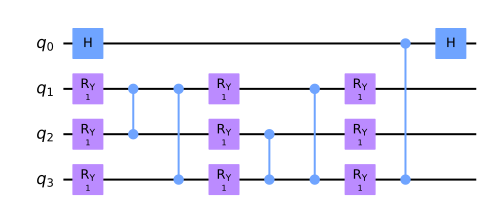

In [3]:
# Creates the Hadamard test

def had_test(gate_type, qubits, auxiliary_index, parameters):

    circ.h(auxiliary_index)

    apply_fixed_ansatz(qubits, parameters)

    for ie in range (0, len(gate_type[0])):
        if (gate_type[0][ie] == 1):
            circ.cz(auxiliary_index, qubits[ie])

    for ie in range (0, len(gate_type[1])):
        if (gate_type[1][ie] == 1):
            circ.cz(auxiliary_index, qubits[ie])
    
    circ.h(auxiliary_index)
    
circ = QuantumCircuit(4)
had_test([[0, 0, 0], [0, 0, 1]], [1, 2, 3], 0, [[1, 1, 1], [1, 1, 1], [1, 1, 1]])
circ.draw()

Der Grund, warum wir zwei verschiedene "gate_types" anwenden, ist, dass dies die Gate-Paare darstellt, die in der erweiterten Form von $\langle \Phi | gezeigt werden \Phi\rangle$.

Es ist auch wichtig anzumerken, dass wir uns für die Zwecke dieser Implementierung (der Gleichungssysteme, die wir tatsächlich lösen werden) nur mit den Gattern $Z$ und $\mathbb{I}$ befassen, also schließe ich nur Unterstützung für diese ein Gatter (Der Code enthält Zahlen-"Identifikatoren", die die Anwendung verschiedener Gatter kennzeichnen, $0$ für $\mathbb{I}$ und $1$ für $Z$).

Jetzt können wir zum zweiten Wert übergehen, den wir berechnen müssen, nämlich $|\langle b | \Phi\rangle|^2$. Wir bekommen:

<br>

$$|\langle b | \Phi \rangle|^2 \ = \ |\langle b | AV(k) | 0 \rangle|^2 \ = \ |\langle 0 | U^{\dagger} AV(k) | 0 \rangle|^2 \ = \ \langle 0 | U^{\dagger} AV(k) | 0 \rangle \langle 0 | V(k)^{\dagger} A^{\dagger} U |0\rangle$$

<br>

Alles, was wir jetzt tun müssen, ist die gleiche Erweiterung wie zuvor für das Produkt $\langle 0 | U^{\dagger} AV(k) | 0 \rangle \langle 0 | V(k)^{\dagger} A^{\dagger} U |0\rangle$:

<br>

$$\langle 0 | U^{\dagger} AV(k) | 0 \rangle^2 \ = \ \displaystyle\sum_{m} \displaystyle\sum_{n} c_m^{*} c_n \langle 0 | U^{\dagger} A_n V(k) | 0 \rangle \langle 0 | V(k)^{\dagger} A_m^{\dagger} U |0\rangle$$

<br>

Nun, für diese Demonstration werden wir bald wieder sehen, dass alle Ausgaben/Erwartungswerte unserer Implementierung real sein werden, also haben wir:<br>

$$\Rechtspfeil \ \langle 0 | U^{\dagger} AV(k) | 0 \rangle \ = \ (\langle 0 | U^{\dagger} AV(k) | 0 \rangle)^{*} \ = \ \langle 0 | V(k)^{\dagger} A^{\dagger} U |0\rangle$$

<br>

Somit gilt in dieser speziellen Implementierung:

<br>

$$|\langle b | \Phi \rangle|^2 \ = \ \displaystyle\sum_{m} \displaystyle\sum_{n} c_m c_n \langle 0 | U^{\dagger} A_n V(k) | 0 \rangle \langle 0 | U^{\dagger} A_m V(k) | 0 \rangle$$

<br>

Es gibt eine ausgeklügelte Lösung für diesen Wert, indem eine neu vorgeschlagene Subroutine namens **Hadamard Overlap Test** (siehe zitiertes Papier) verwendet wird, aber für dieses Tutorial verwenden wir nur einen Standard-Hadamard-Test, bei dem wir jede Matrix kontrollieren. Dies erfordert leider die Verwendung eines zusätzlichen Hilfs-Qubits. Wir platzieren im Wesentlichen nur ein Steuerelement an jedem der Gatter, die an der Hilfsfunktion beteiligt sind, der $|b\rangle$-Vorbereitungseinheit und den $A_n$-Einheiten. Für den kontrollierten Ansatz erhalten wir etwa Folgendes:


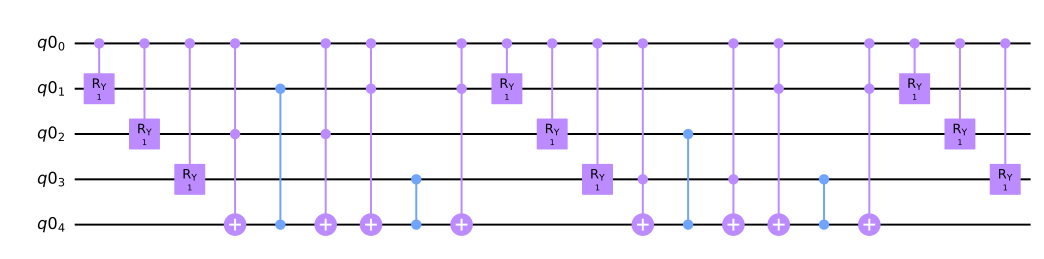

In [4]:
# Creates controlled anstaz for calculating |<b|psi>|^2 with a Hadamard test

def control_fixed_ansatz(qubits, parameters, auxiliary, reg):

    for i in range (0, len(qubits)):
        circ.cry(parameters[0][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

    circ.ccx(auxiliary, qubits[1], 4)
    circ.cz(qubits[0], 4)
    circ.ccx(auxiliary, qubits[1], 4)

    circ.ccx(auxiliary, qubits[0], 4)
    circ.cz(qubits[2], 4)
    circ.ccx(auxiliary, qubits[0], 4)

    for i in range (0, len(qubits)):
        circ.cry(parameters[1][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

    circ.ccx(auxiliary, qubits[2], 4)
    circ.cz(qubits[1], 4)
    circ.ccx(auxiliary, qubits[2], 4)

    circ.ccx(auxiliary, qubits[0], 4)
    circ.cz(qubits[2], 4)
    circ.ccx(auxiliary, qubits[0], 4)

    for i in range (0, len(qubits)):
        circ.cry(parameters[2][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

q_reg = QuantumRegister(5)
circ = QuantumCircuit(q_reg)
control_fixed_ansatz([1, 2, 3], [[1, 1, 1], [1, 1, 1], [1, 1, 1]], 0, q_reg)
circ.draw()

Beachten Sie das zusätzliche Qubit, `q0_4` . Dies ist eine Hilfsfunktion und ermöglicht uns, ein $CCZ$-Gatter zu erstellen, wie in der Schaltung gezeigt. Jetzt müssen wir auch die Schaltung für $U$ erstellen. In unserer Implementierung wählen wir $U$ als:

<br>

$$U \ = \ H_1 H_2 H_3$$

<br>

Somit haben wir:

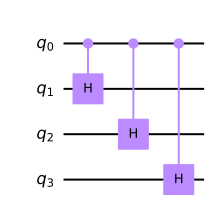

In [5]:
def control_b(auxiliary, qubits):

    for ia in qubits:
        circ.ch(auxiliary, ia)

circ = QuantumCircuit(4)
control_b(0, [1, 2, 3])
circ.draw()

Schließlich konstruieren wir unseren neuen Hadamard-Test:

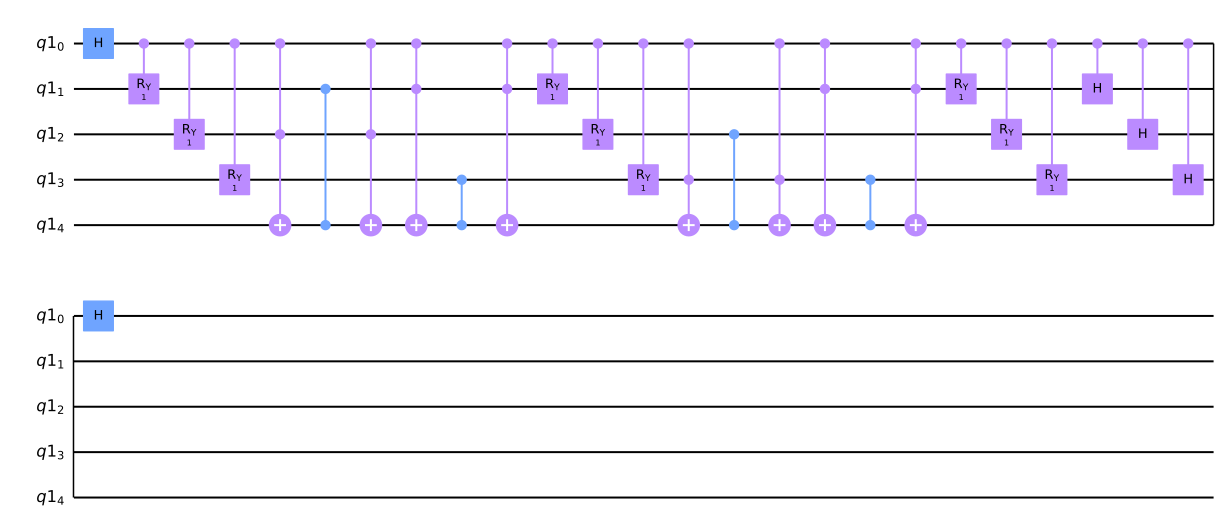

In [6]:
# Create the controlled Hadamard test, for calculating <psi|psi>

def special_had_test(gate_type, qubits, auxiliary_index, parameters, reg):

    circ.h(auxiliary_index)

    control_fixed_ansatz(qubits, parameters, auxiliary_index, reg)

    for ty in range (0, len(gate_type)):
        if (gate_type[ty] == 1):
            circ.cz(auxiliary_index, qubits[ty])


    control_b(auxiliary_index, qubits)
    
    circ.h(auxiliary_index)

q_reg = QuantumRegister(5)
circ = QuantumCircuit(q_reg)
special_had_test([[0, 0, 0], [0, 0, 1]], [1, 2, 3], 0, [[1, 1, 1], [1, 1, 1], [1, 1, 1]], q_reg)
circ.draw()

Dies gilt für die spezifische Implementierung, wenn alle unsere Parameter auf $1$ gesetzt sind und der Satz von Gattern $A_n$ einfach `[0, 0, 0]` und `[0, 0, 1]` ist, was der Identitätsmatrix entspricht auf allen Qubits sowie die $Z$-Matrix auf dem dritten Qubit (mit meiner "Code-Notation").

Jetzt können wir die endgültige Kostenfunktion berechnen. Dies beinhaltet einfach, dass wir die Produkte aller Kombinationen der Erwartungsausgaben von den verschiedenen Schaltungen nehmen, mit ihren jeweiligen Koeffizienten multiplizieren und in die Kostenfunktion einordnen, die wir zuvor besprochen haben!

In [7]:
# Implements the entire cost function on the quantum circuit

def calculate_cost_function(parameters):
    
    global opt

    overall_sum_1 = 0
    
    parameters = [parameters[0:3], parameters[3:6], parameters[6:9]]

    for i in range(0, len(gate_set)):
        for j in range(0, len(gate_set)):

            global circ

            qctl = QuantumRegister(5)
            qc = ClassicalRegister(5)
            circ = QuantumCircuit(qctl, qc)

            backend = Aer.get_backend('statevector_simulator')
            
            multiply = coefficient_set[i]*coefficient_set[j]

            had_test([gate_set[i], gate_set[j]], [1, 2, 3], 0, parameters)

            t_circ = transpile(circ, backend)
            qobj = assemble(t_circ)
            job = backend.run(qobj)

            result = job.result()
            outputstate = np.real(result.get_statevector(circ, decimals=100))
            o = outputstate

            m_sum = 0
            for l in range (0, len(o)):
                if (l%2 == 1):
                    n = o[l]**2
                    m_sum+=n

            overall_sum_1+=multiply*(1-(2*m_sum))

    overall_sum_2 = 0

    for i in range(0, len(gate_set)):
        for j in range(0, len(gate_set)):

            multiply = coefficient_set[i]*coefficient_set[j]
            mult = 1

            for extra in range(0, 2):

                qctl = QuantumRegister(5)
                qc = ClassicalRegister(5)
                circ = QuantumCircuit(qctl, qc)

                backend = Aer.get_backend('statevector_simulator')

                if (extra == 0):
                    special_had_test(gate_set[i], [1, 2, 3], 0, parameters, qctl)
                if (extra == 1):
                    special_had_test(gate_set[j], [1, 2, 3], 0, parameters, qctl)

                t_circ = transpile(circ, backend)
                qobj = assemble(t_circ)
                job = backend.run(qobj)

                result = job.result()
                outputstate = np.real(result.get_statevector(circ, decimals=100))
                o = outputstate

                m_sum = 0
                for l in range (0, len(o)):
                    if (l%2 == 1):
                        n = o[l]**2
                        m_sum+=n
                mult = mult*(1-(2*m_sum))

            overall_sum_2+=multiply*mult
            
    print(1-float(overall_sum_2/overall_sum_1))

    return 1-float(overall_sum_2/overall_sum_1)

Dieser Code mag lang und abschreckend aussehen, ist es aber nicht! In dieser Simulation verfolge ich einen **numerischen** Ansatz, bei dem ich das Amplitudenquadrat jedes Zustands berechne, der einer Messung des Hilfs-Hadamard-Test-Qubits im $1$-Zustand entspricht, und dann $P(0) \ - \ P berechne (1) \ = \ 1 \ - \ 2P(1)$ mit diesen Informationen. Dies ist sehr genau, aber nicht realistisch, da ein echtes Quantengerät die Schaltung viele Male abtasten müsste, um diese Wahrscheinlichkeiten zu erzeugen (auf das Abtasten werde ich später eingehen). Außerdem ist dieser Code nicht vollständig optimiert (er führt mehr Auswertungen des Quantenschaltkreises durch, als er muss), aber dies ist die einfachste Art, wie der Code implementiert werden kann, und ich werde ihn in einem Update zu diesem Tutorial optimieren in naher Zukunft.

Der letzte Schritt besteht darin, diesen Code tatsächlich zu verwenden, um ein echtes lineares System zu lösen. Wir betrachten zunächst das Beispiel:

<br>

$$A \ = \ 0,45 Z_3 \ + \ 0,55 \mathbb{I}$$

<br>

Zur Minimierung der Kostenfunktion verwenden wir die COBYLA-Optimierermethode, die wir immer wieder anwenden. Unser Suchraum für Parameter wird durch $\frac{k}{1000} \ k \ \in \ {0, \ 3000}$ bestimmt, das zunächst zufällig gewählt wird. Wir werden den Optimierer für $200$-Schritte ausführen, dann beenden und den Ansatz für unsere optimalen Parameter anwenden, um unseren optimierten Zustandsvektor zu erhalten! Darüber hinaus werden wir einige Nachbearbeitungen berechnen, um zu sehen, ob unser Algorithmus tatsächlich funktioniert! Dazu wenden wir $A$ auf unseren optimalen Vektor $|\psi\rangle_o$ an, normalisieren ihn und berechnen dann das innere Produkt zum Quadrat dieses Vektors und des Lösungsvektors $|b\rangle$! Wir können dies alles in Code einfügen als:

In [8]:
coefficient_set = [0.55, 0.45]
gate_set = [[0, 0, 0], [0, 0, 1]]

out = minimize(calculate_cost_function, x0=[float(random.randint(0,3000))/1000 for i in range(0, 9)], method="COBYLA", options={'maxiter':200})
print(out)

out_f = [out['x'][0:3], out['x'][3:6], out['x'][6:9]]

circ = QuantumCircuit(3, 3)
apply_fixed_ansatz([0, 1, 2], out_f)

backend = Aer.get_backend('statevector_simulator')
t_circ = transpile(circ, backend)
qobj = assemble(t_circ)
job = backend.run(qobj)

result = job.result()
o = result.get_statevector(circ, decimals=10)

a1 = coefficient_set[1]*np.array([[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,1,0,0,0,0,0], [0,0,0,1,0,0,0,0], [0,0,0,0,-1,0,0,0], [0,0,0,0,0,-1,0,0], [0,0,0,0,0,0,-1,0], [0,0,0,0,0,0,0,-1]])
a2 = coefficient_set[0]*np.array([[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,1,0,0,0,0,0], [0,0,0,1,0,0,0,0], [0,0,0,0,1,0,0,0], [0,0,0,0,0,1,0,0], [0,0,0,0,0,0,1,0], [0,0,0,0,0,0,0,1]])
a3 = np.add(a1, a2)

b = np.array([float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8))])

print((b.dot(a3.dot(o)/(np.linalg.norm(a3.dot(o)))))**2)

0.6836710713149694
0.7515998909285393
0.7161441091698497
0.1737436940780679
0.40696124837156944
-0.3535401823067905
0.4593404801165958
-0.0012336654801023972
-0.4463210599167178
0.37506686093528685
-4.379278251915205
-2.0702757319302054
-4.052478777420056
-2.167412641304694
-4.510512339394018
-0.9042764538913497
-3.5268825189460165
-1.8779784555828156
-2.347555184817919
-4.102407220646085
-0.53105252496996
-3.3465996125086503
-9.806136017109747
-1.1759478432807855
-12.607376881458723
-2.6437728221787067
-5.971235125386092
-8.192074789626762
-13.511654167182465
-4.736839645438364
-7.084101088705891
-8.33515861629934
-13.0125723405279
-13.367007926236864
-12.434824019490271
-13.73128884536073
-14.51377634970942
-17.246031065051437
-8.879872575380292
-11.815966063032686
-11.5710513844899
-17.9568474628019
-18.001072234232858
-16.46752606731651
-18.041276031312314
-18.642618346141305
-18.516145742002056
-18.626327966350445
-21.690269344286975
-19.914512749755055
-20.146332421880615
-19.593

Wie Sie sehen können, hat unsere Kostenfunktion einen ziemlich niedrigen Wert von `0.03273673575407443` erreicht, und wenn wir unsere klassische Kostenfunktion berechnen, erhalten wir `0.96776862579723` , was perfekt mit dem übereinstimmt, was wir gemessen haben, den Vektoren $|\psi\rangle_o$ und $| b\rangle$ sind sehr ähnlich!

Machen wir noch einen Test! Dieses Mal behalten wir $|b\rangle$ bei, aber wir haben:

<br>

$$A \ = \ 0,55 \mathbb{I} \ + \ 0,225 Z_2 \ + \ 0,225 Z_3$$

Auch hier führen wir unseren Optimierungscode aus:

In [9]:
coefficient_set = [0.55, 0.225, 0.225]
gate_set = [[0, 0, 0], [0, 1, 0], [0, 0, 1]]

out = minimize(calculate_cost_function, x0=[float(random.randint(0,3000))/1000 for i in range(0, 9)], method="COBYLA", options={'maxiter':200})
print(out)

out_f = [out['x'][0:3], out['x'][3:6], out['x'][6:9]]

circ = QuantumCircuit(3, 3)
apply_fixed_ansatz([0, 1, 2], out_f)

backend = Aer.get_backend('statevector_simulator')

t_circ = transpile(circ, backend)
qobj = assemble(t_circ)
job = backend.run(qobj)

result = job.result()
o = result.get_statevector(circ, decimals=10)

a1 = coefficient_set[2]*np.array([[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,1,0,0,0,0,0], [0,0,0,1,0,0,0,0], [0,0,0,0,-1,0,0,0], [0,0,0,0,0,-1,0,0], [0,0,0,0,0,0,-1,0], [0,0,0,0,0,0,0,-1]])
a0 = coefficient_set[1]*np.array([[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,-1,0,0,0,0,0], [0,0,0,-1,0,0,0,0], [0,0,0,0,1,0,0,0], [0,0,0,0,0,1,0,0], [0,0,0,0,0,0,-1,0], [0,0,0,0,0,0,0,-1]])
a2 = coefficient_set[0]*np.array([[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,1,0,0,0,0,0], [0,0,0,1,0,0,0,0], [0,0,0,0,1,0,0,0], [0,0,0,0,0,1,0,0], [0,0,0,0,0,0,1,0], [0,0,0,0,0,0,0,1]])

a3 = np.add(np.add(a2, a0), a1)

b = np.array([float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8))])

print((b.dot(a3.dot(o)/(np.linalg.norm(a3.dot(o)))))**2)

0.47739942145460346
0.524993716494066
0.7163777756890085
0.3250981795748564
0.5676945290874322
-0.10477076167273736
0.26341797752803797
0.10959435241866156
-0.1504552096125218
-0.2778551864929759
-0.7970657049262597
0.1623810875048327
-0.7039405118800652
0.15044048605268778
-0.464613461308774
-0.46280314560807767
-0.9476583016332047
-0.2134648623296067
-0.46498067399227483
-0.48692406571506686
-1.533069849757791
-1.4900943316309947
-1.8139124681307002
-1.0417559856725949
-2.136857755540209
-2.8929990103039365
-2.2449095284992433
-1.5264461084434866
-2.9862140729800957
-4.541417152254607
-5.5018026132357924
-3.0188245219004743
-6.084703781278799
-3.641956925806414
-4.267240889086195
-1.4014502277338452
-3.821658878429308
-4.986357084689766
-7.89633333687752
-6.431503487738861
-7.921286283315821
-6.607926619277441
-6.866060969760977
-5.59502421241013
-7.784033322451878
-7.8889297852632225
-7.2667929881916695
-8.33010049111
-8.596411115089726
-8.249997848765439
-7.877191085786363
-10.5256

Auch hier sehr geringer Fehler, und die klassische Kostenfunktion stimmt! Super, also es funktioniert!

Nun haben wir herausgefunden, dass dieser Algorithmus **theoretisch** funktioniert. Ich habe versucht, einige Simulationen mit einer Schaltung durchzuführen, die die Schaltung abtastet, anstatt die Wahrscheinlichkeiten numerisch zu berechnen. Lassen Sie uns nun versuchen, den Quantenschaltkreis **abzutasten** , wie es ein echter Quantencomputer tun würde! Aus irgendeinem Grund würde diese Simulation nur für eine lächerlich hohe Anzahl von "Schüssen" (Läufe der Schaltung, um die Wahrscheinlichkeitsverteilung der Ergebnisse zu berechnen) einigermaßen gut konvergieren. Ich denke, dass dies hauptsächlich mit Einschränkungen im klassischen Optimierer (COBYLA) zu tun hat, aufgrund der verrauschten Natur des Abtastens eines Quantenschaltkreises (eine Messung mit denselben Parametern führt nicht immer zu demselben Ergebnis). Glücklicherweise gibt es andere Optimierer, die für verrauschte Funktionen gebaut wurden, wie z. B. SPSA, aber darauf gehen wir in diesem Tutorial nicht ein. Versuchen wir unser Sampling für unseren zweiten Wert von $A$ mit derselben Matrix $U$:

In [10]:
#Implements the entire cost function on the quantum circuit (sampling, 100000 shots)

def calculate_cost_function(parameters):

    global opt

    overall_sum_1 = 0
    
    parameters = [parameters[0:3], parameters[3:6], parameters[6:9]]

    for i in range(0, len(gate_set)):
        for j in range(0, len(gate_set)):

            global circ

            qctl = QuantumRegister(5)
            qc = ClassicalRegister(1)
            circ = QuantumCircuit(qctl, qc)

            backend = Aer.get_backend('qasm_simulator')
            
            multiply = coefficient_set[i]*coefficient_set[j]

            had_test([gate_set[i], gate_set[j]], [1, 2, 3], 0, parameters)

            circ.measure(0, 0)

            t_circ = transpile(circ, backend)
            qobj = assemble(t_circ, shots=10000)
            job = backend.run(qobj)

            result = job.result()
            outputstate = result.get_counts(circ)

            if ('1' in outputstate.keys()):
                m_sum = float(outputstate["1"])/100000
            else:
                m_sum = 0

            overall_sum_1+=multiply*(1-2*m_sum)

    overall_sum_2 = 0

    for i in range(0, len(gate_set)):
        for j in range(0, len(gate_set)):

            multiply = coefficient_set[i]*coefficient_set[j]
            mult = 1

            for extra in range(0, 2):

                qctl = QuantumRegister(5)
                qc = ClassicalRegister(1)
                
                circ = QuantumCircuit(qctl, qc)

                backend = Aer.get_backend('qasm_simulator')

                if (extra == 0):
                    special_had_test(gate_set[i], [1, 2, 3], 0, parameters, qctl)
                if (extra == 1):
                    special_had_test(gate_set[j], [1, 2, 3], 0, parameters, qctl)

                circ.measure(0, 0)

                t_circ = transpile(circ, backend)
                qobj = assemble(t_circ, shots=10000)
                job = backend.run(qobj)

                result = job.result()
                outputstate = result.get_counts(circ)

                if ('1' in outputstate.keys()):
                    m_sum = float(outputstate["1"])/100000
                else:
                    m_sum = 0

                mult = mult*(1-2*m_sum)
            
            overall_sum_2+=multiply*mult
            
    print(1-float(overall_sum_2/overall_sum_1))

    return 1-float(overall_sum_2/overall_sum_1)

In [11]:
coefficient_set = [0.55, 0.225, 0.225]
gate_set = [[0, 0, 0], [0, 1, 0], [0, 0, 1]]

out = minimize(calculate_cost_function, x0=[float(random.randint(0,3000))/1000 for i in range(0, 9)], method="COBYLA", options={'maxiter':200})
print(out)

out_f = [out['x'][0:3], out['x'][3:6], out['x'][6:9]]

circ = QuantumCircuit(3, 3)
apply_fixed_ansatz([0, 1, 2], out_f)

backend = Aer.get_backend('statevector_simulator')

t_circ = transpile(circ, backend)
qobj = assemble(t_circ)
job = backend.run(qobj)

result = job.result()
o = result.get_statevector(circ, decimals=10)

a1 = coefficient_set[2]*np.array([[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,1,0,0,0,0,0], [0,0,0,1,0,0,0,0], [0,0,0,0,-1,0,0,0], [0,0,0,0,0,-1,0,0], [0,0,0,0,0,0,-1,0], [0,0,0,0,0,0,0,-1]])
a0 = coefficient_set[1]*np.array([[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,-1,0,0,0,0,0], [0,0,0,-1,0,0,0,0], [0,0,0,0,1,0,0,0], [0,0,0,0,0,1,0,0], [0,0,0,0,0,0,-1,0], [0,0,0,0,0,0,0,-1]])
a2 = coefficient_set[0]*np.array([[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,1,0,0,0,0,0], [0,0,0,1,0,0,0,0], [0,0,0,0,1,0,0,0], [0,0,0,0,0,1,0,0], [0,0,0,0,0,0,1,0], [0,0,0,0,0,0,0,1]])

a3 = np.add(np.add(a2, a0), a1)

b = np.array([float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8))])

print((b.dot(a3.dot(o)/(np.linalg.norm(a3.dot(o)))))**2)

0.22184763316822664
0.19273223102993542
0.1608043093838336
0.15776260650899343
0.1604668594065196
0.20270788659482475
0.1653017433072872
0.15772387386958486
0.16932705255179747
0.15078781703879818
0.12763352227315627
0.12349113889746566
0.12340890898054957
0.11087348805733632
0.07153358610617566
0.0541635121470988
0.05717099624898714
0.05581321338788503
0.06787917194962423
0.06525735766091545
0.07504631693175612
0.04460931677017643
0.05616284216315792
0.04132352807462003
0.04635036349140309
0.0484184913344029
0.042338946257858945
0.044190390149081216
0.0603667539651237
0.038534422561567805
0.041947667923634246
0.04012866396949755
0.03846319643286178
0.033719007739151485
0.037549943270434816
0.0329755926299502
0.033166009864400214
0.03236861720233719
0.03518746256419969
0.03382256234763148
0.03408015744971793
0.032164216958187386
0.03136565179463491
0.03243174334140975
0.032811322004243304
0.03311981226609406
0.03230571042652086
0.03209737343633878
0.03259565396078923
0.031971300663448


Wie Sie also sehen können, ist es nicht erstaunlich, dass unsere Lösung immer noch ziemlich weit daneben liegt ($3,677%$ Fehler ist nicht schlimm, aber idealerweise möchten wir, dass er **viel** näher an 0 liegt). Auch hier denke ich, dass dies auf den Optimierer selbst zurückzuführen ist, nicht auf die eigentliche Quantenschaltung. Ich werde dieses Notebook aktualisieren, sobald ich herausgefunden habe, wie ich dieses Problem beheben kann (wahrscheinlich mit der Einführung eines lauten Optimierers, wie ich bereits erwähnt habe).

## 4. Danksagungen

Diese Implementierung basiert auf der Arbeit, die in der Forschungsarbeit „Variational Quantum Linear Solver: A Hybrid Algorithm for Linear Systems“ von Carlos Bravo-Prieto, Ryan LaRose, M. Cerezo, Yiğit Subaşı, Lukasz Cincio und Patrick J. Coles, das unter [diesem](https://arxiv.org/abs/1909.05820) Link verfügbar ist.

Besonderer Dank geht an Carlos Bravo-Prieto, der mir persönlich geholfen hat, indem er einige meiner Fragen bezüglich des Papiers beantwortet hat!

In [12]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.16.1',
 'qiskit-aer': '0.7.2',
 'qiskit-ignis': '0.5.1',
 'qiskit-ibmq-provider': '0.11.1',
 'qiskit-aqua': '0.8.1',
 'qiskit': '0.23.2'}